In [17]:
#dataset
image1 = mpimg.imread("1.jpeg") 
image2 = mpimg.imread("2.jpeg") 
image3 = mpimg.imread("3.jpeg") 
image4 = mpimg.imread("4.jpeg") 
image5 = mpimg.imread("5.jpeg") 
image6 = mpimg.imread("live.jpg") 



x_image=[image1,image2,image3,image4,image5,image6]


In [18]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import numpy as np
import math
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import numpy as np
import math
import numpy as np
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

#some function will help us :)---------------------------------------------------------------------------------------------

    
            
#convert image to gray scale


def rgb_to_gray(img):
            grayImage = np.zeros(img.shape)
            R = np.array(img[:, :, 0])
            G = np.array(img[:, :, 1])
            B = np.array(img[:, :, 2])

            R = (R *.299)
            G = (G *.587)
            B = (B *.114)

            Avg = (R+G+B)
            grayImage = img.copy()

            for i in range(3):
               grayImage[:,:,i] = Avg

            return grayImage  


#padding
def pad(img, kernel):
            r, c = img.shape
            kr, kc = kernel.shape
            padded = np.zeros((r + kr,c + kc), dtype=img.dtype)
            insert = np.uint((kr)/2)
            padded[insert: insert + r, insert: insert + c] = img
            return padded

def calculate_target_size(img_size: int, kernel_size: int) -> int:
            num_pixels = 0

            # From 0 up to img size (if img size = 224, then up to 223)
            for i in range(img_size):
                # Add the kernel size (let's say 3) to the current i
                added = i + kernel_size
                # It must be lower than the image size
                if added <= img_size:
                    # Increment if so
                    num_pixels += 1

            return num_pixels

  #to view the images  
def plot_image(img: np.array):
        plt.figure(figsize=(6, 6))
        plt.imshow(img, cmap='gray');
        
def plot_three_images(img1: np.array, img2: np.array,img3: np.array):
        _, ax = plt.subplots(1, 2, 3, figsize=(12, 6))
        ax[0].imshow(img1, cmap='gray')
        ax[1].imshow(img2, cmap='gray');
        ax[2].imshow(img2, cmap='gray');
        
#-------------------------------------------------------------------------------------------------------------------------------        
        
##canny functions
#1 - gaussian mask
from matplotlib import pyplot as plt

from PIL import Image

def gaussianmask(size, sigma):
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    return g




#2- sobel mask
sobelX = np.array((
[-1, 0, 1],
[-2, 0, 2],
[-1, 0, 1]), dtype="int")
# construct the Sobel y-axis kernel
sobelY = np.array((
[-1, -2, -1],
[0, 0, 0],
[1, 2, 1]), dtype="int")




#3- perwitt mask

def prewitt(img):
    Kx = np.array([[1, 1, 1], [0, 0, 0], [-1,-1,-1]], np.float32)
    Ky = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]], np.float32)
    
    Ix = convolute1(img, Kx)
    Iy = convolute1(img, Ky)
    
    G = np.hypot(Ix, Iy)
    G = G / G.max() * 255
    theta = np.arctan2(Iy, Ix)
    
    return (G, theta)





#4- #convolute function which take 2 array one for image and another for filter
    
def convolute1(img: np.array, kernel: np.array) -> np.array:
    # Assuming a rectangular image
    tgt_size = calculate_target_size(
        img_size=img.shape[0],
        kernel_size=kernel.shape[0]
    )
    # To simplify things
    k = kernel.shape[0]
    
    # 2D array of zeros
    convolved_img = np.zeros(shape=(tgt_size, tgt_size))
    
    # Iterate over the rows
    for i in range(tgt_size):
        # Iterate over the columns
        for j in range(tgt_size):
            # img[i, j] = individual pixel value
            # Get the current matrix
            mat = img[i:i+k, j:j+k]
            
            # Apply the convolution - element-wise multiplication and summation of the result
            # Store the result to i-th row and j-th column of our convolved_img array
            convolved_img[i, j] = np.sum(np.multiply(mat, kernel))
            
    return convolved_img





#5- #  non maximam which return image

def non_maxima_suppression(img, D):
    M, N = img.shape
    Z = np.zeros((M,N), dtype=np.int32)
    angle = D * 180. / np.pi
    angle[angle < 0] += 180

    
    for i in range(1,M-1):
        for j in range(1,N-1):
            try:
                q = 255
                r = 255
                
               #angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]
                #angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]
                #angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = img[i+1, j]
                    r = img[i-1, j]
                #angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]

                if (img[i,j] >= q) and (img[i,j] >= r):
                    Z[i,j] = img[i,j]
                else:
                    Z[i,j] = 0

            except IndexError as e:
                pass
    
    return Z






#6- #double threshould
def double_threshold(img, lowThresholdRatio=0.05, highThresholdRatio=0.1):
    
    highThreshold = img.max() * highThresholdRatio;
    lowThreshold = highThreshold * lowThresholdRatio;
    
    M, N = img.shape
    res = np.zeros((M,N), dtype=np.int32)
    
    weak = np.int32(25)
    strong = np.int32(255)
    
    strong_i, strong_j = np.where(img >= highThreshold)
    zeros_i, zeros_j = np.where(img < lowThreshold)
    
    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))
    
    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak
    
    return (res, weak, strong)



#7- edge linking #edgelinking

import numpy as np
import math

def edgeLink(M, Mag, Ori):
  # TODO: your code here
  M=np.squeeze(np.asarray(M))
  Mag=np.squeeze(np.asarray(Mag))
  Muse=M*Mag
  
  # Hysteresis thresholding
  # for weak edge
  threshold_low = 0.015 #TODO
  threshold_low = threshold_low * Muse.max()
  # for strong edge
  threshold_high = 0.115 #TODO
  threshold_high = threshold_high * Muse.max()
  
  #print(np.sum(Muse))
  #print(np.sum(threshold_low))
  #print(np.sum(threshold_high))
  
  if np.sum(Muse)<50000:
      threshold_low=0.01;
      threshold_high=0.02;
      threshold_low = threshold_low * Muse.max()
      threshold_high = threshold_high * Muse.max()
  elif np.sum(Muse)<250000 and np.sum(threshold_low)>2:
      threshold_low=0.02;
      threshold_high=0.04;
      threshold_low = threshold_low * Muse.max()
      threshold_high = threshold_high * Muse.max()
  elif np.sum(Muse)<550000 and np.sum(threshold_low)>2:
      threshold_low=0.015;
      threshold_high=0.06;
      threshold_low = threshold_low * Muse.max()
      threshold_high = threshold_high * Muse.max()
  
  '''
  (M1,M2,M3,M4,M5,M6)=np.split(Muse, [64,128,192,246,321])
  (M11,M12,M13,M14,M15,M16)=np.split(M1,[96,192,288,384,481],axis=1)
  (M21,M22,M23,M24,M25,M26)=np.split(M2,[96,192,288,384,481],axis=1)
  (M31,M32,M33,M34,M35,M36)=np.split(M3,[96,192,288,384,481],axis=1)
  (M41,M42,M43,M44,M45,M46)=np.split(M4,[96,192,288,384,481],axis=1)
  (M51,M52,M53,M54,M55,M56)=np.split(M5,[96,192,288,384,481],axis=1)
  M11=threshold*M11,max()
  M21=
  '''
  
  
  size = np.shape(Mag)
  E = np.zeros(size)
  #linked_edge = hysteresis_thresholding(threshold_low, threshold_high, linked_edge, ed
  #E= M
  is_weak = Muse>threshold_low
  is_strong = Muse>threshold_high 
  
  for i in range(1, size[0]-1):
      for j in range(1, size[1]-1):
          if E[i,j]==0:
              if is_strong[i,j]:
                  E[i,j]=1
                  if Ori[i,j]==0:
                      if (is_weak[i+1,j]):
                          E[i+1,j]=1 
                      if (is_weak[i-1,j]):
                          E[i-1,j]=1
                  elif Ori[i,j]>0 and Ori[i,j]<math.pi/4:
                      if (is_weak[i+1,j]):
                          E[i+1,j]=1 
                      if (is_weak[i-1,j]):
                          E[i-1,j]=1
                      if (is_weak[i+1,j-1]):
                          E[i+1,j-1]=1
                      if  (is_weak[i-1,j+1]):
                          E[i-1,j+1]=1
                  elif Ori[i,j]==math.pi/4:
                      if (is_weak[i+1,j-1]):
                          E[i+1,j-1]=1
                      if  (is_weak[i-1,j+1]):
                          E[i-1,j+1]=1
                  elif Ori[i,j]>math.pi/4 and Ori[i,j]<math.pi/2:
                      if (is_weak[i+1,j-1]):
                          E[i+1,j-1]=1
                      if  (is_weak[i-1,j+1]):
                          E[i-1,j+1]=1
                      if  (is_weak[i,j+1]):
                          E[i,j+1]==1
                      if (is_weak[i,j-1]):
                          E[i,j-1]==1
                  elif Ori[i,j]==math.pi/2:
                      if  (is_weak[i,j+1]):
                          E[i,j+1]==1
                      if (is_weak[i,j-1]):
                          E[i,j-1]==1
                  elif Ori[i,j]>math.pi/2 and Ori[i,j]<math.pi*3/4:
                      if  (is_weak[i,j+1]):
                          E[i,j+1]==1
                      if (is_weak[i,j-1]):
                          E[i,j-1]==1
                      if (is_weak[i+1,j+1]):
                          E[i+1,j+1]=1
                      if (is_weak[i-1,j-1]):
                          E[i-1,j-1]=1
                  elif Ori[i,j]==math.pi*3/4:
                      if (is_weak[i+1,j+1]):
                          E[i+1,j+1]=1
                      if (is_weak[i-1,j-1]):
                          E[i-1,j-1]=1
                  elif Ori[i,j]>math.pi*3/4:
                      if (is_weak[i+1,j+1]):
                          E[i+1,j+1]=1
                      if (is_weak[i-1,j-1]):
                          E[i-1,j-1]=1
                      if (is_weak[i+1,j]):
                          E[i+1,j]=1 
                      if (is_weak[i-1,j]):
                          E[i-1,j]=1
                                         
  return E
# Python3 code for generating 8-neighbourhood chain
# code for a 2-D line
 
codeList = [5, 6, 7, 4, -1, 0, 3, 2, 1]
 
# This function generates the chaincode
# for transition between two neighbour points
def getChainCode(x1, y1, x2, y2):
    dx = x2 - x1
    dy = y2 - y1
    hashKey = 3 * dy + dx + 4
    return codeList[hashKey]
 
'''This function generates the list of
chaincodes for given list of points'''
def generateChainCode(ListOfPoints):
    chainCode = []
    for i in range(len(ListOfPoints) - 1):
        a = ListOfPoints[i]
        b = ListOfPoints[i + 1]
        chainCode.append(getChainCode(a[0], a[1], b[0], b[1]))
    return chainCode
 
 
'''This function generates the list of points for
a straight line using Bresenham's Algorithm'''
def Bresenham2D(x1, y1, x2, y2):
    ListOfPoints = []
    ListOfPoints.append([x1, y1])
    xdif = x2 - x1
    ydif = y2 - y1
    dx = abs(xdif)
    dy = abs(ydif)
    if(xdif > 0):
        xs = 1
    else:
        xs = -1
    if (ydif > 0):
        ys = 1
    else:
        ys = -1
    if (dx > dy):
 
        # Driving axis is the X-axis
        p = 2 * dy - dx
        while (x1 != x2):
            x1 += xs
            if (p >= 0):
                y1 += ys
                p -= 2 * dx
            p += 2 * dy
            ListOfPoints.append([x1, y1])
    else:
 
        # Driving axis is the Y-axis
        p = 2 * dx-dy
        while(y1 != y2):
            y1 += ys
            if (p >= 0):
                x1 += xs
                p -= 2 * dy
            p += 2 * dx
            ListOfPoints.append([x1, y1])
    return ListOfPoints
 
def DriverFunction():
    (x1, y1) = (-9, -3)
    (x2, y2) = (10, 1)
    ListOfPoints = Bresenham2D(x1, y1, x2, y2)
    chainCode = generateChainCode(ListOfPoints)
    chainCodeString = "".join(str(e) for e in chainCode)
    print ('Chain code for the straight line from', (x1, y1),
            'to', (x2, y2), 'is', chainCodeString)
 
DriverFunction()

In [19]:
def canny(img):
    img2 = cv2.resize(img, dsize=(244, 244), interpolation=cv2.INTER_CUBIC)
    gray=rgb_to_gray(img2)
    
    imgarr=np.array(gray)
    g =gaussianmask(3, 0.5)
    convoluted_image=convolute1(imgarr,g)
    #plot_image(convoluted_image)
    (x1,y1)=prewitt(convoluted_image)
    #plot_image(img2)
    non_image=non_maxima_suppression(x1,y1)
    #plot_image(non_image)
    (imgdouble1,weak,strong)=double_threshold(non_image)
    #plot_image(imgdouble)
    edgimg=edgeLink(imgdouble1,x1,y1)
    
    fig = plt.figure(figsize=(15, 10))

    # setting values to rows and column variables
    rows = 1
    columns = 4

    # Adds a subplot at the 1st position
    fig.add_subplot(rows, columns, 1)

    # showing image
    plt.imshow(img2)
    plt.axis('off')
    plt.title("Original")

    # Adds a subplot at the 2nd position
    fig.add_subplot(rows, columns, 2)

    # showing image
    plt.imshow(gray)
    plt.axis('off')
    plt.title("Gray")

    # Adds a subplot at the 3rd position
    fig.add_subplot(rows, columns, 3)

    # showing image
    plt.imshow(x1, cmap='gray');
    plt.axis('off')
    plt.title("Perwitt Mask")
     # Adds a subplot at the 3rd position
    fig.add_subplot(rows, columns, 4)

    # showing image
    plt.imshow(edgimg, cmap='gray');
    plt.axis('off')
    plt.title("Edge Extraction")

    

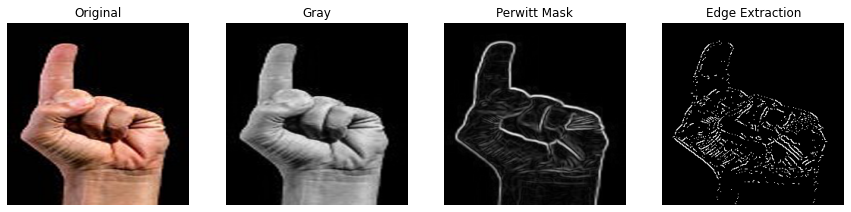

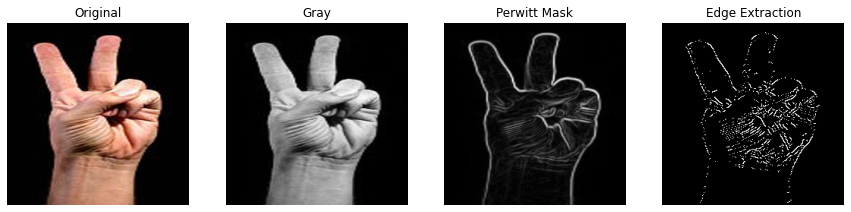

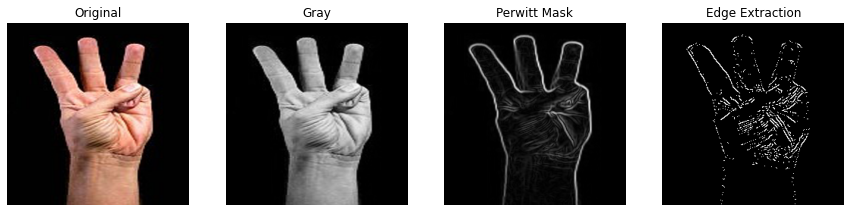

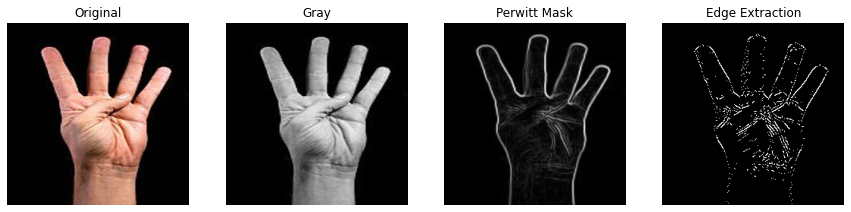

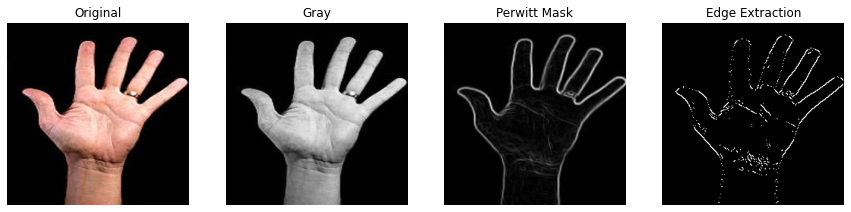

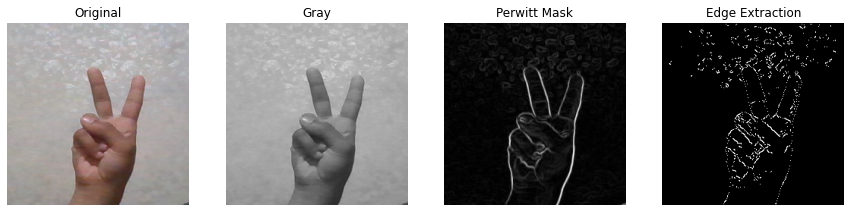

In [20]:
for x in x_image:
    canny(x)
    
    
    

